In [1]:
import os
import wfdb
import numpy as np
from tqdm import tqdm

# Define the path to your dataset directory
DATA_DIR = "C:/Users/M2-Winterfell/Downloads/electrocardiography-dataset-1.0.3/records100/00000"

# Function to load and extract Lead I and Lead II from a single record
def load_ecg_leads(file_path):
    try:
        # Load the record using wfdb (the file_path should be without extension)
        record = wfdb.rdrecord(file_path)
        
        # Extract Lead I and Lead II (assuming they are the first two leads)
        lead_I = record.p_signal[:, 0]  # Lead I
        lead_II = record.p_signal[:, 1]  # Lead II
        
        return lead_I, lead_II
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

# Function to load all ECG records from the specified directory
def load_all_ecg_data(data_dir):
    all_lead_I = []
    all_lead_II = []
    
    # Traverse through all files in the specified directory
    for file in tqdm(sorted(os.listdir(data_dir)), desc="Loading ECG files"):
        if file.endswith("_lr.dat"):  # Look for files with the '_lr' suffix
            # Construct the base filename (removing the '_lr.dat' extension)
            base_filename = file.replace("_lr.dat", "_lr")
            record_path = os.path.join(data_dir, base_filename)
            
            # Load Lead I and Lead II
            lead_I, lead_II = load_ecg_leads(record_path)
            
            if lead_I is not None and lead_II is not None:
                all_lead_I.append(lead_I)
                all_lead_II.append(lead_II)
            else:
                print(f"Skipping record: {base_filename}")

    # Convert lists to NumPy arrays if data was loaded
    if all_lead_I and all_lead_II:
        all_lead_I = np.array(all_lead_I)  # Shape: (num_records, samples_per_record)
        all_lead_II = np.array(all_lead_II)  # Shape: (num_records, samples_per_record)
    else:
        all_lead_I = np.array([])  # Empty array if no data
        all_lead_II = np.array([])  # Empty array if no data
    
    return all_lead_I, all_lead_II

# Load all ECG records from records100
lead_I_data, lead_II_data = load_all_ecg_data(DATA_DIR)

# Check if data was loaded successfully
if lead_I_data.size > 0 and lead_II_data.size > 0:
    print(f"Total records loaded: {lead_I_data.shape[0]}")
    print(f"Each record has {lead_I_data.shape[1]} samples per lead.")
    
    # Check shapes
    print("Lead I data shape:", lead_I_data.shape)
    print("Lead II data shape:", lead_II_data.shape)
else:
    print("No data was loaded.")


Loading ECG files: 100%|██████████| 1974/1974 [00:06<00:00, 284.19it/s]


Total records loaded: 987
Each record has 1000 samples per lead.
Lead I data shape: (987, 1000)
Lead II data shape: (987, 1000)


Normalize ECG signals to ensure data ranges are consistent, which help stabilizing the training of neural networks

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Function to cut data into segments
def split_and_scale_ecg_data(lead_I_data, lead_II_data, segment_length=200):
    scaler = MinMaxScaler(feature_range=(-1, 1))  # Initialize the scaler

    # First, scale the full 10-second data
    lead_I_scaled = scaler.fit_transform(lead_I_data)
    lead_II_scaled = scaler.transform(lead_II_data)  # Use the same scaler for Lead II

    all_lead_I_segments = []
    all_lead_II_segments = []

    # Loop over each sample and split into segments
    for i in range(lead_I_scaled.shape[0]):
        lead_I_sample = lead_I_scaled[i]
        lead_II_sample = lead_II_scaled[i]

        # Split into segments
        num_segments = len(lead_I_sample) // segment_length
        lead_I_segments = [lead_I_sample[j*segment_length:(j+1)*segment_length] for j in range(num_segments)]
        lead_II_segments = [lead_II_sample[j*segment_length:(j+1)*segment_length] for j in range(num_segments)]

        # Add the segments to the lists
        all_lead_I_segments.extend(lead_I_segments)
        all_lead_II_segments.extend(lead_II_segments)

    # Convert lists to NumPy arrays
    all_lead_I_segments = np.array(all_lead_I_segments)
    all_lead_II_segments = np.array(all_lead_II_segments)

    return all_lead_I_segments, all_lead_II_segments

# Split and scale data into 2-second segments (200 samples per segment)
lead_I_segments, lead_II_segments = split_and_scale_ecg_data(lead_I_data, lead_II_data, segment_length=200)

# Print results
print("Lead I segments shape:", lead_I_segments.shape)
print("Lead II segments shape:", lead_II_segments.shape)


Lead I segments shape: (4935, 200)
Lead II segments shape: (4935, 200)


Conv1D + LSTM Generator

In [3]:
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, LeakyReLU, Dropout, Attention, BatchNormalization, Reshape
from tensorflow.keras.models import Model

def build_detailed_generator(input_shape=(200, 1)):
    input_layer = Input(shape=input_shape)
    
    # First Conv1D layer with LeakyReLU
    conv1 = Conv1D(64, kernel_size=7, strides=1, padding="same")(input_layer)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.3)(conv1)
    
    # Second Conv1D layer
    conv2 = Conv1D(128, kernel_size=5, strides=1, padding="same")(conv1)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.3)(conv2)
    
    # Third Conv1D layer with residual connection
    conv3 = Conv1D(256, kernel_size=3, strides=1, padding="same")(conv2)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.3)(conv3)
    
    # First LSTM layer
    lstm_1 = LSTM(256, return_sequences=True, activation='tanh')(conv3)
    lstm_1 = Dropout(0.3)(lstm_1)
    
    # Second LSTM layer
    lstm_2 = LSTM(128, return_sequences=True, activation='tanh')(lstm_1)
    lstm_2 = Dropout(0.3)(lstm_2)
    
    # Attention layer
    attention = Attention()([lstm_2, lstm_2])
    
    # Final LSTM layer after attention
    lstm_3 = LSTM(64, return_sequences=True, activation='tanh')(attention)
    lstm_3 = Dropout(0.3)(lstm_3)
    
    # Final Dense layer for output
    output_layer = Dense(1, activation='tanh')(lstm_3)
    
    # Build and return the model
    generator_model = Model(inputs=input_layer, outputs=output_layer)
    return generator_model

Conv1D + LSTM Discriminator

In [4]:
from tensorflow.keras.layers import Input, Conv1D, LeakyReLU, Dropout, LSTM, GlobalMaxPooling1D, BatchNormalization, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D

def build_detailed_discriminator(input_shape=(200, 1)):
    input_layer = Input(shape=input_shape)
    
    # First Conv1D layer
    conv_1 = Conv1D(64, kernel_size=5, strides=2, padding='same')(input_layer)
    conv_1 = LeakyReLU(alpha=0.2)(conv_1)
    conv_1 = Dropout(0.3)(conv_1)
    
    # Second Conv1D layer
    conv_2 = Conv1D(128, kernel_size=5, strides=2, padding='same')(conv_1)
    conv_2 = LeakyReLU(alpha=0.2)(conv_2)
    conv_2 = Dropout(0.3)(conv_2)
    conv_2 = BatchNormalization()(conv_2)
    
    # Third Conv1D layer
    conv_3 = Conv1D(256, kernel_size=5, strides=2, padding='same')(conv_2)
    conv_3 = LeakyReLU(alpha=0.2)(conv_3)
    conv_3 = Dropout(0.3)(conv_3)
    conv_3 = BatchNormalization()(conv_3)
    
    # Fourth Conv1D layer with smaller kernel
    conv_4 = Conv1D(512, kernel_size=2, strides=1, padding='same')(conv_3)
    conv_4 = LeakyReLU(alpha=0.2)(conv_4)
    conv_4 = Dropout(0.3)(conv_4)
    conv_4 = BatchNormalization()(conv_4)
    
    # LSTM layer
    lstm_layer = LSTM(256, return_sequences=False)(conv_4)
    
    # Global pooling layer
    global_pooling = GlobalAveragePooling1D()(conv_4)
    
    # Concatenate LSTM output and global pooling output
    concatenated = Concatenate()([lstm_layer, global_pooling])
    
    # Dense layer
    dense_1 = Dense(128, activation='relu')(concatenated)
    dense_1 = Dropout(0.4)(dense_1)
    
    # Fully connected output layer
    output_layer = Dense(1, activation='sigmoid')(dense_1)
    
    # Build and return the discriminator model
    discriminator_model = Model(inputs=input_layer, outputs=output_layer)
    return discriminator_model

1. The discriminator should be frozen during the generator's training
2. The goal here is to only train the generator to fool the discriminator, while keeping discriminator fixed
3. If don't freeze, both generator and discriminator would adjust simultaneously and generator would not improve effectively

Full Training

c:\Users\M2-Winterfell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch [1/4] - D Loss: 1.1259, G Loss: 1.0275
Epoch [2/4] - D Loss: 1.2701, G Loss: 0.6602
1/1 [==============================] - 2s 2s/step


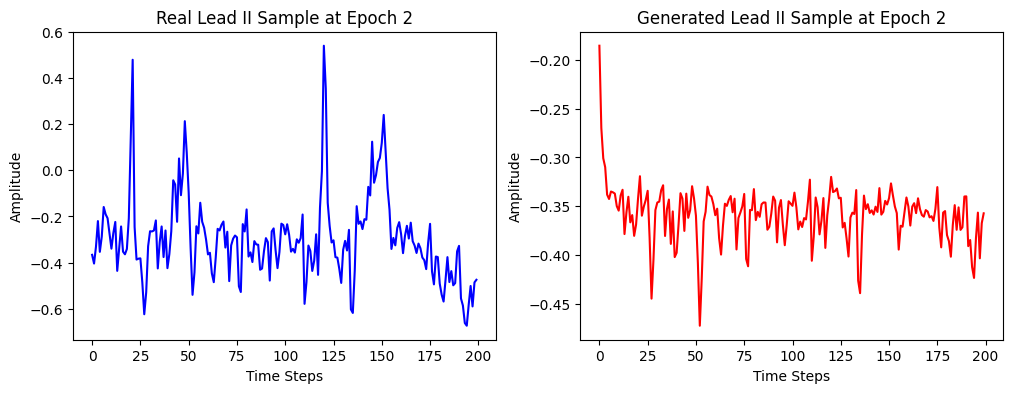

Epoch [3/4] - D Loss: 1.2432, G Loss: 0.7890
Epoch [4/4] - D Loss: 1.1812, G Loss: 0.8571
1/1 [==============================] - 0s 58ms/step


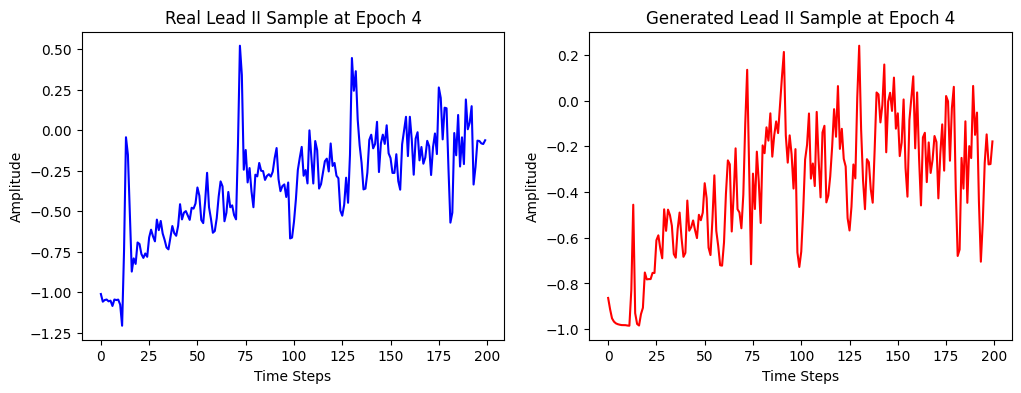

In [5]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt

# Initialize models
generator = build_detailed_generator(input_shape=(200, 1))
discriminator = build_detailed_discriminator(input_shape=(200, 1))

# Optimizers
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Loss functions
bce_loss = BinaryCrossentropy(from_logits=True)  # For adversarial loss
mse_loss = MeanSquaredError()  # For reconstruction loss

# Training parameters
epochs = 4
batch_size = 32
real_label = 0.9  # Soft label for real data
fake_label = 0.1  # Soft label for fake data

# Reshape the data to match the input requirements (add a channel dimension)
lead_I_segments = np.expand_dims(lead_I_segments, axis=-1)  # Shape: (4935, 200, 1)
lead_II_segments = np.expand_dims(lead_II_segments, axis=-1)  # Shape: (4935, 200, 1)

# Training loop with visualization
for epoch in range(epochs):
    for i in range(0, len(lead_I_segments), batch_size):
        # Prepare batches
        input_batch = lead_I_segments[i:i + batch_size]
        real_lead_II_batch = lead_II_segments[i:i + batch_size]
        batch_size_actual = input_batch.shape[0]

        # ---------------------
        # Train Discriminator
        # ---------------------
        with tf.GradientTape() as d_tape:
            # Generate fake Lead II data
            fake_lead_II = generator(input_batch, training=True)

            # Discriminator predictions
            real_preds = discriminator(real_lead_II_batch, training=True)
            fake_preds = discriminator(fake_lead_II, training=True)

            # Real and fake labels
            real_targets = tf.ones((batch_size_actual, 1)) * real_label
            fake_targets = tf.ones((batch_size_actual, 1)) * fake_label

            # Discriminator loss
            d_loss_real = bce_loss(real_targets, real_preds)
            d_loss_fake = bce_loss(fake_targets, fake_preds)
            d_loss = d_loss_real + d_loss_fake

        # Update discriminator weights
        d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

        # ---------------------
        # Train Generator
        # ---------------------
        with tf.GradientTape() as g_tape:
            # Generate fake Lead II data
            fake_lead_II = generator(input_batch, training=True)

            # Discriminator predictions on fake data
            fake_preds = discriminator(fake_lead_II, training=True)

            # Generator adversarial loss (fool discriminator)
            g_adv_loss = bce_loss(real_targets, fake_preds)

            # Generator reconstruction loss (match real Lead II)
            g_recon_loss = mse_loss(real_lead_II_batch, fake_lead_II)

            # Total generator loss
            g_loss = g_adv_loss + g_recon_loss

        # Update generator weights
        g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

    # Log progress
    print(f"Epoch [{epoch + 1}/{epochs}] - D Loss: {d_loss.numpy():.4f}, G Loss: {g_loss.numpy():.4f}")

    # Verification and visualization every 10 epochs
    if (epoch + 1) % 2 == 0:
        # Pick a random sample from the dataset for visualization
        random_index = np.random.randint(0, len(lead_I_segments))
        real_data_sample = lead_II_segments[random_index]  # Real Lead II
        input_sample = lead_I_segments[random_index]      # Corresponding Lead I
        input_sample = np.expand_dims(input_sample, axis=0)  # Expand for batch processing
        generated_data_sample = generator.predict(input_sample)  # Generated Lead II

        # Plot the real and generated Lead II data
        plt.figure(figsize=(12, 4))
        
        # Plot the real Lead II sample
        plt.subplot(1, 2, 1)
        plt.plot(real_data_sample[:, 0], color='blue')  # Assuming shape (200, 1)
        plt.title(f"Real Lead II Sample at Epoch {epoch + 1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")
        
        # Plot the generated Lead II sample
        plt.subplot(1, 2, 2)
        plt.plot(generated_data_sample[0, :, 0], color='red')  # Assuming shape (1, 200, 1)
        plt.title(f"Generated Lead II Sample at Epoch {epoch + 1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")

        # Display the plots
        plt.show()